## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was to rescale, normalize, and turn any image into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In [1]:
l = [1,2,3]
l2 = [4,5,6]

In [2]:
l2.extend(['a', 48])
l2

[4, 5, 6, 'a', 48]

In the next python cell we load in required libraries for this section of the project.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

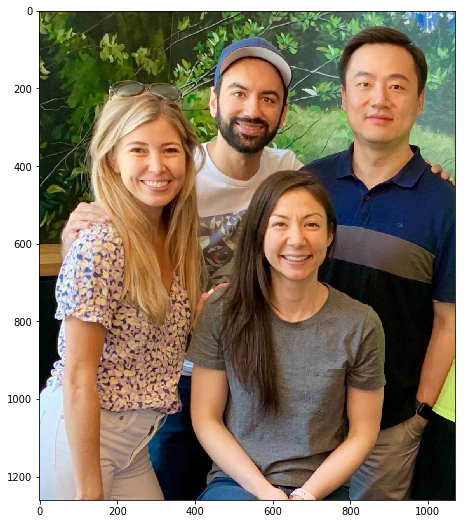

In [4]:
import cv2
# load in color image for face detection
image = cv2.imread('images/people.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


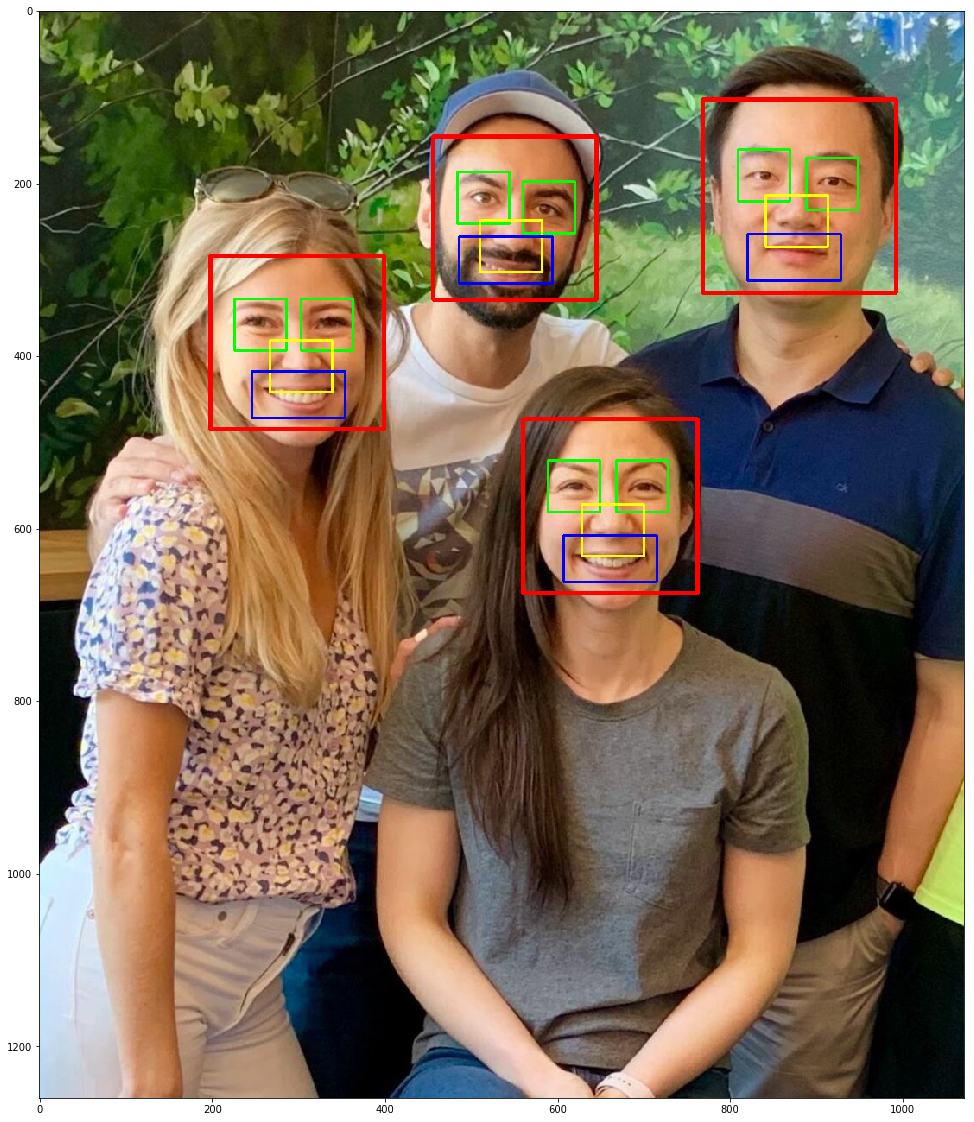

In [5]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_eye.xml')
nose_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_mcs_nose.xml')
smile_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_smile.xml')
# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 10)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 
    
    roi = image_with_detections[y:y+h, x:x+w]
    
    eyes = eye_cascade.detectMultiScale(roi, 3, 2)
    nose = nose_cascade.detectMultiScale(roi, 4, 5)
    smile = smile_cascade.detectMultiScale(roi, 3, 5)
    
    for (x_eye,y_eye,w_eye,h_eye) in eyes:
        cv2.rectangle(roi, (x_eye, y_eye), (x_eye+w_eye, y_eye+h_eye), (0,255,0), 2)
    
    for (x_nose,y_nose,w_nose,h_nose) in nose:
        cv2.rectangle(roi, (x_nose,y_nose), (x_nose+w_nose, y_nose+h_nose), (255,255,0), 2)
    
    for (x_smile,y_smile,w_smile,h_smile) in smile:
        cv2.rectangle(roi, (x_smile,y_smile), (x_smile+w_smile, y_smile+h_smile), (0,0,255), 2)

fig = plt.figure(figsize=(20,20))

plt.imshow(image_with_detections);

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [6]:
import torch
from models import Net

net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('saved_models/keypoints_model_4_relu_200e_smooth.pt'))

## print out your net and prepare it for testing (uncomment the line below)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on:", device)
net.to(device)
net.eval()

Running on: cuda


Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (dropout1): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout2): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (dropout3): Dropout(p=0.3)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (dropout4): Dropout(p=0.4)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (dropout5): Dropout(p=0.5)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (dropout6): Dropout(p=0.6)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

**Hint**: The sizes of faces detected by a Haar detector and the faces your network has been trained on are of different sizes. If you find that your model is generating keypoints that are too small for a given face, try adding some padding to the detected `roi` before giving it as input to your model.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




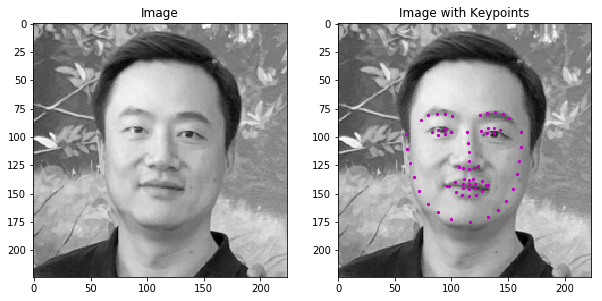

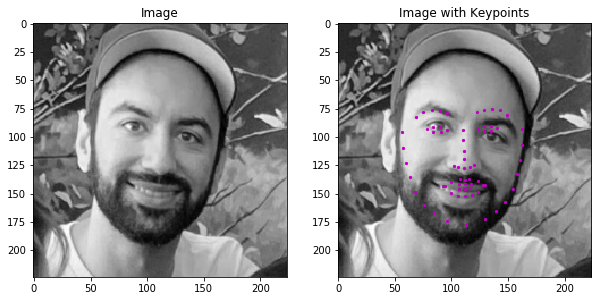

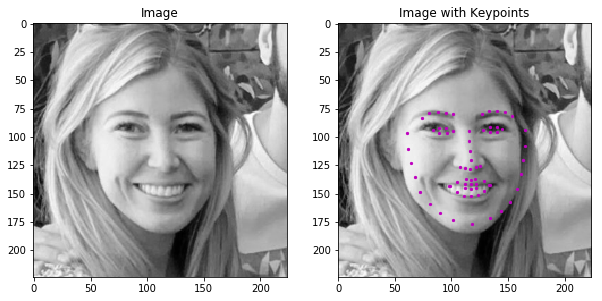

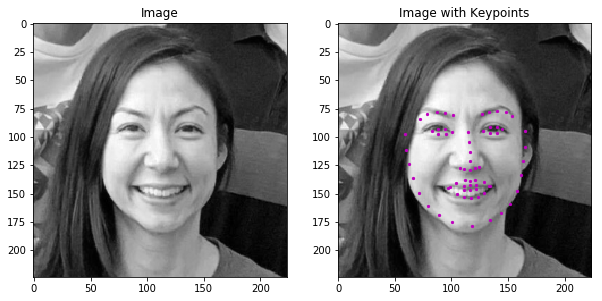

In [7]:
def detect_key_pts(image):    
    image_copy = np.copy(image)
    results = []
    # loop over the detected faces from your haar cascade
    for (x,y,w,h) in faces:

        # Select the region of interest that is the face in the image 
        margin = 0.4
        roi = image_copy[y-int(margin*h)+15:y+h+int(margin*h), x-int(margin*w):x+w+int(margin*w)]

        ## TODO: Convert the face region from RGB to grayscale
        gray_roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

        ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
        gray_roi = gray_roi/255.0

        ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
        gray_roi = cv2.resize(gray_roi, (224,224))

        ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
        gray_reshaped = gray_roi.reshape(1, 1, 224, 224)


        ## TODO: Make facial keypoint predictions using your loaded, trained network 
        inp_image = torch.tensor(gray_reshaped)
        inp_image = inp_image.type(torch.cuda.FloatTensor)

        out_key_pts = net(inp_image)
        out_key_pts = out_key_pts.view(68, -1)
        out_key_pts = out_key_pts.data.cpu().numpy()
        # undo normalization of keypoints 
        out_im = out_key_pts * 51.0 + 100


        ## TODO: Display each detected face and the corresponding keypoints        
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

        ax1.imshow(gray_roi, cmap='gray')
        ax1.set_title('Image')

        ax2.imshow(gray_roi, cmap='gray')
        ax2.scatter(out_im[:, 0], out_im[:, 1], s=20, marker='.', c='m')
        ax2.set_title('Image with Keypoints')

    plt.show();
detect_key_pts(image)

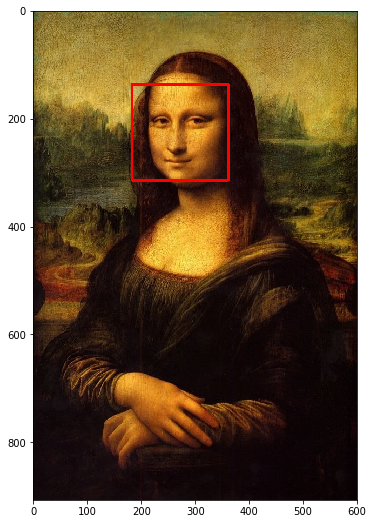

In [8]:
import cv2
# load in color image for face detection
image = cv2.imread('images/the-mona-lisa.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

faces = face_cascade.detectMultiScale(image, 1.3, 5)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

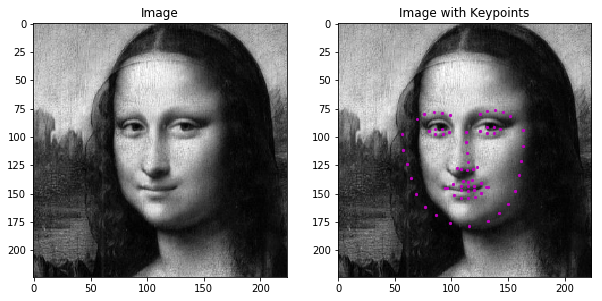

In [9]:
detect_key_pts(image)

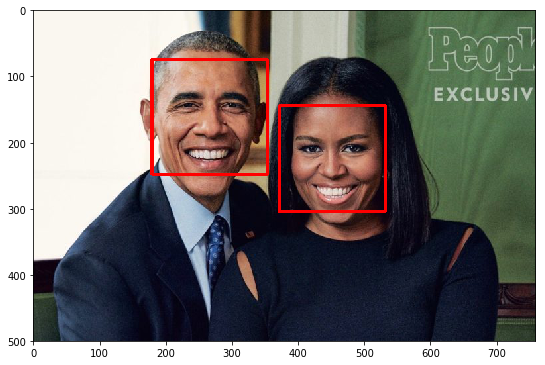

In [10]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

faces = face_cascade.detectMultiScale(image, 1.2, 5)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

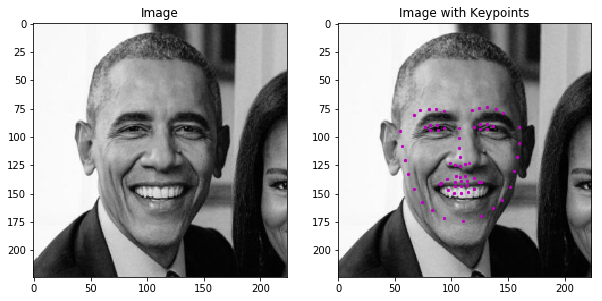

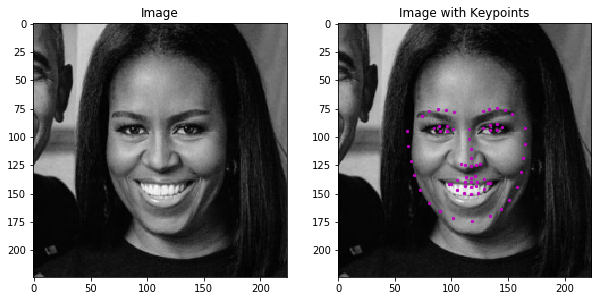

In [11]:
detect_key_pts(image)